In [1]:
include("./QuantumToolbox/QuantumWrapper.jl")
import ..QuantumWrapper.AM_Toolbox: Basis, Node, angularMomentum, couple, endNode, AngularNode, getBasis, getBasisUC
using ..QuantumWrapper.SpinOperator

In [2]:
import ..QuantumWrapper.State_Toolbox.State
import ..QuantumWrapper.State_Toolbox.Ket
import ..QuantumWrapper.State_Toolbox.KetName
using LinearAlgebra
using SparseArrays
using Base.Threads
using WignerSymbols
include("MoleculeConstants.jl");

In [4]:

struct moleculeProperties{T<:Node}
    Constants
    basisTree::T
    L
    N2
    N1
end
function generateSpinOperator(F::Node)
    EndNodes = endNode(F)
    Operators = []
    for (i, node) in enumerate(EndNodes)
        dimsA = i == length(EndNodes) ? 1 : prod([length(node.spin) for node in EndNodes[(i+ 1):end]])
        dimsB = i == 1 ? 1 : prod([length(node.spin) for node in EndNodes[(i-1):-1:1]])

        I_a = sparse(1.0I, dimsA, dimsA)
        I_b = sparse(1.0I, dimsB, dimsB)

        push!(Operators, [kron(I_b, kron(x_operator(node), I_a)), kron(I_b, kron(y_operator(node), I_a)), kron(I_b, kron(z_operator(node), I_a)), kron(I_b, kron(raising_operator(node), I_a))])
    end
    Operators
end

function generateMolecule(MoleculeInfo, Nmax, Lmax)

    N1 = angularMomentum("N1", [0:Nmax...])
    N2 = angularMomentum("N2", [0:Nmax...])
    L = nothing
    if MoleculeInfo["Sym"] == 0
        L = angularMomentum("L", [0:2:Lmax...])
    else MoleculeInfo["Sym"] == 1
        L = angularMomentum("L", [1:2:Lmax...])
    end


    N_c = couple("N_c", N2, N1)
    F = couple("F", L, N_c)
    LOp, N2Op, N1Op = generateSpinOperator(F)
    moleculeProperties(MoleculeInfo,F, LOp, N2Op, N1Op)
end


generateMolecule (generic function with 1 method)

In [5]:
import Base.*
using PhysicalConstants.CODATA2018
const hbar = PlanckConstant.val/(2*pi)
struct moleculeInteraction{T}
    M::moleculeProperties
    Hrot::T
    Hdc::T
    Hdip::T
    Hcent::T
end

function compute_SHC_elements!(operator, q, N; order = 2)
    
    for (j, state) in enumerate(getBasis(N.spin)), (k, state2) in enumerate(getBasis(N.spin))
        if true #abs(state[2] - state2[2]) <= order && -1*state[1] + state2[1] + q == 0
            mN, N1 = state
            mNp, Np = state2 

            operator[j, k] = (-1)^(mN) * sqrt((2*N1 + 1)*(2*Np + 1)) * wigner3j(N1, order, Np, -mN, q, mNp) * wigner3j(N1, order, Np, 0, 0, 0)
        end
    end
end
function DipoleMatrix(mol::moleculeProperties, basisOI)
    F = mol.basisTree
    EndNodes = endNode(F)
    dimsA = basisOI == length(EndNodes) ? 1 : prod([length(node.spin) for node in EndNodes[(basisOI+ 1):end]])
    dimsB = basisOI == 1 ? 1 : prod([length(node.spin) for node in EndNodes[(basisOI-1):-1:1]])

    I_a = sparse(1.0I, dimsA, dimsA)
    I_b = sparse(1.0I, dimsB, dimsB)
    nodeOI = EndNodes[basisOI]
    dipoleOperator = [spzeros(ComplexF64, length(nodeOI.spin), length(nodeOI.spin)) for _ in -1:1] 
    @threads for i in 1:3
        q = i - 2
        compute_SHC_elements!(dipoleOperator[i], q, nodeOI, order = 1)
    end
    [kron(I_b, kron(sparse(dip), I_a)) for dip in dipoleOperator]

end
function getDipoleMatrix(mol::moleculeProperties, basisOI)
    dipm, dip0, dipp =  DipoleMatrix(mol, basisOI)
    dip = -1*mol.Constants["d0"]*[(dipm + adjoint(dipm))/sqrt(2), 1im*(dipm - adjoint(dipm))/sqrt(2), dip0]
end

function DCStark(M::moleculeProperties, dirE, basisOI)
    sum(dirE.* getDipoleMatrix(M, basisOI))
end

*(a::Vector{T}, b::Vector{T}) where {T<:AbstractSparseMatrix} = sum([a[i]*b[i] for i = 1:size(a)[1]])
function generateRotational(Nrot, Brot)
    Nsq = Nrot*Nrot
    Brot*Nsq
end
function generateCent(Lrot, redMass)
    Lsq = Lrot*Lrot
    hbar^2/(2*redMass)*Lsq
end

function T2_C(mol::moleculeProperties, basisOI; order = 2)
    F = mol.basisTree
    EndNodes = endNode(F)
    dimsA = basisOI == length(EndNodes) ? 1 : prod([length(node.spin) for node in EndNodes[(basisOI+ 1):end]])
    dimsB = basisOI == 1 ? 1 : prod([length(node.spin) for node in EndNodes[(basisOI-1):-1:1]])

    I_a = sparse(1.0I, dimsA, dimsA)
    I_b = sparse(1.0I, dimsB, dimsB)
    
    nodeOI = EndNodes[basisOI]
    T2C = [spzeros(ComplexF64, length(nodeOI.spin), length(nodeOI.spin)) for _ in -order:order] 
    @threads for i in 1:(2*order + 1)
        q = i - (order + 1)
        
        compute_SHC_elements!(T2C[i], q, nodeOI, order = order)
    end

    [kron(I_b, kron(sparse(q), I_a)) for q in T2C]
end



function makeT2_n(I1, I2)


    T2m2 = I1[1]*I2[1]
    T2p2 = I1[3]*I2[3]
    T2p1 = 1/sqrt(2)*(I1[3]*I2[2] + I1[2]*I2[3])
    T2m1 = 1/sqrt(2)*(I1[1]*I2[2] + I1[2]*I2[1])
    T20 = 1/sqrt(6)*(I1[3]*I2[1] + I1[1]*I2[3] + 2*I1[2]*I2[2])
   
    T = [T2m2, T2m1, T20, T2p1, T2p2]

    return T 
end


function makeT2(I1, I2)
    T2m2 = 0.5 * (I1[1] * I2[1] - 1im*I1[1] * I2[2] - 1im*I1[2] * I2[1] - I1[2] * I2[2])
    T2p2 = 0.5 * (I1[1] * I2[1] + 1im*I1[1] * I2[2] + 1im*I1[2] * I2[1] - I1[2] * I2[2])

    T2m1 = 0.5 * (I1[1] * I2[3] - 1im*I1[2] * I2[3] + I1[3] * I2[1] - 1im*I1[3] * I2[2])
    T2p1 = -0.5 * (I1[1] * I2[3] + 1im*I1[2] * I2[3] + I1[3] * I2[1] + 1im*I1[3] * I2[2])

    T20 = -sqrt(1/6) * (I1[1] * I2[1] + I1[2] * I2[2]) + sqrt(2/3) * I1[3] * I2[3]

    T = [T2m2, T2m1, T20, T2p1, T2p2]

    return T
end


function tensor_dot(T1, T2; order = 2)
    Tprod = spzeros(ComplexF64, size(T1[1])...)
    T2 = reverse(T2)
    for (i, q) in enumerate(-order:order)
        Tprod += ((-1)^q)*T1[i]*T2[i]
    end
    Tprod
end


function DDInteraction(M::moleculeProperties)
    T2 = T2_C(M, 1, order = 2)
    
    T1 = makeT2_n(T2_C(M, 2, order = 1), T2_C(M, 3, order = 1))


    -(1/(4*pi*eps0))*sqrt(6)*(M.Constants["d0"]^2)*tensor_dot(T1, T2, order = 2)
end


function generateHamiltonian(M::moleculeProperties; dirE = [0, 0, 1.0])
    consts = M.Constants
    Hrot = generateRotational(M.N1[1:3], consts["Brot"]) + generateRotational(M.N2[1:3], consts["Brot"])
    Hdc = DCStark(M, normalize!(dirE), 3) + DCStark(M, normalize!(dirE), 2)
    Hdip = DDInteraction(M)
    HCent = generateCent(M.L[1:3], consts["redMass"])
    moleculeInteraction(M,Matrix(Hrot), Matrix(Hdc), Matrix(Hdip), Matrix(HCent))
end



generateHamiltonian (generic function with 1 method)

In [7]:
using PhysicalConstants.CODATA2018
a0 = BohrRadius.val
#basisUC = getBasisUC(H.M.basisTree)

tester= generateMolecule(Na23Cs133, 3, 6)
H = generateHamiltonian(tester)

moleculeInteraction{Matrix{ComplexF64}}(moleculeProperties{AngularNode}(Dict{String, Any}("Brot" => 1.15028577804e-24, "Sym" => 0, "d0" => 1.584429e-29, "a2" => 0.0, "redMass" => 1.2943501003962414e-25, "Drot" => 0.0, "Name" => "Na23Cs133", "a0" => 0.0), AngularNode("F", Main.QuantumWrapper.AM_Toolbox.SpinBasis{Any}("F", Any[Any[0, 0, [0, 0, 0]], Any[1, 0, [1, 0, 1]], Any[2, 0, [2, 0, 2]], Any[3, 0, [3, 0, 3]], Any[1, 0, [1, 1, 0]], Any[0, 0, [0, 1, 1]], Any[1, 0, [1, 1, 1]], Any[2, 0, [2, 1, 1]], Any[1, 0, [1, 1, 2]], Any[2, 0, [2, 1, 2]]  …  Any[3, 6, [6, 3, 3]], Any[4, 6, [6, 3, 3]], Any[5, 6, [6, 3, 3]], Any[6, 6, [6, 3, 3]], Any[7, 6, [6, 3, 3]], Any[8, 6, [6, 3, 3]], Any[9, 6, [6, 3, 3]], Any[10, 6, [6, 3, 3]], Any[11, 6, [6, 3, 3]], Any[12, 6, [6, 3, 3]]], Main.QuantumWrapper.AM_Toolbox.SpinBasis[Main.QuantumWrapper.AM_Toolbox.SpinBasis{Int64}("L", [0, 2, 4, 6], Main.QuantumWrapper.AM_Toolbox.SpinBasis[]), Main.QuantumWrapper.AM_Toolbox.SpinBasis{Any}("N_c", Any[[0, 0, 0], [1, 0

In [83]:

stateOI = State( [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], H);
ind1 = argmax(abs.(Ket(stateOI)))

stateOI_2 =State( [0.0, 0.0, 0.0, 0.0, 1.0,1.0], H); #State( [2.0, 2.0, 0.0, 2.0, 0.0, 0.0], H);
ind2 = argmax(abs.(Ket(stateOI_2)))

println(ind1, " ", ind2)
distance = 10000*a0
ind1, ind2 = 801, 3
H.Hdip[ind1, ind2]/(distance)^3
print(argmax(abs.(H.Hdip[:, :]/(distance)^3)))

3 4


CartesianIndex(4096, 1673)

In [9]:
mutable struct sol
    R
    Ef
    vec
    val
end


In [10]:
#State Utils
State(comp::Array{ComplexF64, 2}, QN::Array{Float64, 2}, mol::moleculeInteraction) = State(normalize!(comp), QN, getBasisUC(mol.M.basisTree))
State(QN::Vector{<:Float64}, mol::moleculeInteraction) = State([1.0], [QN], getBasisUC(mol.M.basisTree) )
State(comp::Vector{<:ComplexF64}, mol::moleculeInteraction) = State(comp, getBasisUC(mol.M.basisTree) , getBasisUC(mol.M.basisTree) )
KetName(state::Vector{<:ComplexF64}, mol::moleculeInteraction; QMorder = [6, 5, 4, 3, 2, 1]) = KetName(state, getBasisUC(mol.M.basisTree), QMorder = QMorder )
KetName(state::State, mol::moleculeInteraction; QMorder = [6, 5, 4, 3, 2, 1]) = KetName(Ket(state), getBasisUC(mol.M.basisTree), QMorder = QMorder )
KetName(state::State) = KetName(Ket(state), state.basis)

KetName (generic function with 4 methods)

In [11]:
#Calculate Utils

function findMaxOverlap(basisState::Vector{<:ComplexF64}, eigvec)
    argmax(abs.(transpose(eigvec)*basisState))
end
function findMaxComponent(basisState::Vector{<:ComplexF64}, eigvec)
    B = zeros(ComplexF64, size(A))
    for j in 1:size(A, 2)
        max_index = argmax(abs.(A[:, j]))
        B[max_index, j] = A[max_index, j]
    end
    argmax(abs.(transpose(B)*basisState))

end

findState(stateOI::State, eigsol::Array{<:ComplexF64, 2}) = findState(Ket(stateOI), eigsol)
findState(stateOI::State, eigsol::sol) = findState(Ket(stateOI), eigsol.vec)
findState(stateOI::Vector{<:Complex}, eigsol::sol) = findState(stateOI, eigsol.vec)
function findState(stateOI::Vector{<:Complex}, eigsol::Array{ComplexF64, 2})
    findMaxOverlap(stateOI, eigsol)
end
findStateMax(stateOI::State, eigsol::Array{<:ComplexF64, 2}) = findStateMax(Ket(stateOI), eigsol)
findStateMax(stateOI::State, eigsol::sol) = findStateMax(Ket(stateOI), eigsol.vec)
findStateMax(stateOI::Vector{<:Complex}, eigsol::sol) = findStateMax(stateOI, eigsol.vec)
function findStateMax(stateOI::Vector{<:Complex}, eigsol::Array{ComplexF64, 2})
    findMaxComponent(stateOI, eigsol)
end



findStateMax (generic function with 4 methods)

In [12]:
#Diagonalizing Function 
function Hpot(H::moleculeInteraction, R::T, Edc::T)  where (T<:Number)
    Hermitian(Matrix(R == 0.0 ? 0 : 1/R^3*H.Hdip + Edc*H.Hdc + H.Hrot + H.Hcent/R^2))
end
function diagonalize(H::moleculeInteraction, R::T, Edc::T) where {T<:Number}
    J2uK = 1/(1.38e-23)*1e6
    vals, vecs = eigen(Hpot(H, R, Edc))
    sorted_indices = sortperm(vals)
    vals = vals[sorted_indices]
    vecs = vecs[:, sorted_indices]
    sol(R, Edc, vecs, vals*J2uK)
end
function scan(H, R::Array, Edc)
    solutions = Vector{sol}(undef, length(R))
    for (i, R_i) in enumerate(R)
        solutions[i] = diagonalize(H, R_i , Edc)
    end
    solutions
end
function scan(H, R, Edc::Array)
    solutions = Vector{sol}(undef, length(Edc))
    
    for (i, E_i) in enumerate(Edc)
        
        solutions[i] = diagonalize(H, R, E_i)
    end
    solutions
end

scan (generic function with 2 methods)

In [249]:
adiabats(state::State, sol::Vector{sol}) = adiabats(Ket(state), sol::Vector{sol})
function adiabats(state::Vector{<:ComplexF64}, sols::Vector{sol}, offset = true)
    startingInd = argmax([sol_i.R for sol_i in sols])
    adiabatInd = findStateMax(state, sols[startingInd])
    println("state: $adiabatInd")
    Upot = offset ? [real(sol_i.val[adiabatInd]) for sol_i in sols] .- sols[startingInd].val[adiabatInd] : [real(sol_i.val[adiabatInd]) for sol_i in sols] 
    stateVecs = [sol_i.vec[adiabatInd] for sol_i in sols]
    stateVecs, Upot
end
function energies(sols::Vector{sol}; units = "K")
    yConv = Dict("K"=> 1/1e6, "uK" => 1)
    hcat([i.val*yConv[units] for i in sols]...)
end



energies (generic function with 1 method)

In [ ]:
using PlotlyJS
using Colors
import CairoMakie


function set_figure_style!(p; title = "", ylabel = "", xlabel ="")
    relayout!(p,
        title=title, 
        xaxis=attr(
            title=xlabel, 
            showline=true,
            linecolor="black",
            mirror=true,
            ticks="outside",
            gridcolor="lightgrey"
        ),
        yaxis=attr(
            title=ylabel, 
            showline=true,
            linecolor="black",
            mirror=true,
            ticks="outside",
            gridcolor="lightgrey"
        ),
        plot_bgcolor="white",
        width=1000,
        height=400
    )
end
plotScan(mol::moleculeInteraction, sol_vec; stateOI = [nothing, nothing, nothing], units = "K", maxDisplay = 300) = plotScan(PlotlyJS.plot(), mol::moleculeInteraction, sol_vec; stateOI = stateOI, units = units, maxDisplay = maxDisplay)
function plotScan(p::PlotlyJS.SyncPlot, mol::moleculeInteraction, sol_vec; stateOI = [nothing, nothing, nothing], units = "K", maxDisplay = 300)
    yConv = Dict("K"=> 1/1e6, "uK" => 1)

    xlabel = ["E-Field (V/cm)","R (a0)"]
    conv = [1e5,BohrRadius.val]
    
    x_var = hcat([[sol_i.Ef, sol_i.R] for sol_i in sol_vec]...)
    x_varOI = argmax([maximum(abs.(diff(x_var[i, :])[1])) for i in 1:size(x_var, 1)])
    
    AMNodes = endNode(H.M.basisTree)
    basisUC_Full = getBasisUC(mol.M.basisTree)
    basisUC = [getBasis(node.spin) for node in AMNodes]
    kronStateOI = [zeros(Int64, length(basis)) for basis in basisUC]
    for (ind, basisNode) in enumerate(basisUC)
        if stateOI[ind] == nothing
    
            kronStateOI[ind] .= 1
        else 
            subIndOI = findfirst(isequal(stateOI[ind]), basisNode)
            kronStateOI[ind][subIndOI] = 1
        end
    end
    
    stateOIind = findall(kron(kronStateOI...) .== 1)
    function findStateVec(sol_end::sol, stateOIs::Vector{Int64})
        outputVec = zeros(Int64, length(stateOIs))
    
        vec_end = sol_end.vec
        arrayOI = zeros(Float64, size(vec_end, 1), length(stateOIs))
        for col in 1:size(arrayOI, 2)
            arrayOI[stateOIs[col], col] = 1
        end
    
        B = zeros(ComplexF64, size(vec_end))
        for j in 1:size(vec_end, 2)
            max_index = argmax(abs.(vec_end[:, j]))
            B[max_index, j] = vec_end[max_index, j]
        end
        maxOverlapMat = B'*arrayOI
        for col in 1:size(maxOverlapMat, 2)
            outputVec[col] = argmax(abs.(maxOverlapMat[:, col]))
        end
        unique(outputVec)
    end
    
    adiabaticInd = argmax([sol_i.R for sol_i in sol_vec])
    filteredStateOI = findStateVec(sol_vec[adiabaticInd], stateOIind)
    filteredStateOI = length(filteredStateOI) > maxDisplay ? filteredStateOI[1:maxDisplay] : filteredStateOI
    
    #p = PlotlyJS.plot()
    for state in filteredStateOI
        PlotlyJS.addtraces!(p, PlotlyJS.scatter(x = x_var[x_varOI, :]/conv[x_varOI], y = [sol_i.val[state] for sol_i in sol_vec]*yConv[units], text=[KetName(sol_i.vec[:, state], basisUC_Full, QMorder = [6, 5, 4, 3, 2, 1]) for sol_i in sol_vec], name = "State $state"))
    end
    set_figure_style!(p, title = "Energy Spectrum", xlabel = xlabel[x_varOI], ylabel = "Energy ($(units))")
    p
end


In [122]:
using PhysicalConstants.CODATA2018
a0 = BohrRadius.val
#basisUC = getBasisUC(H.M.basisTree)

tester= generateMolecule(Na23Cs133, 3, 6)
H = generateHamiltonian(tester)

moleculeInteraction{Matrix{ComplexF64}}(moleculeProperties{AngularNode}(Dict{String, Any}("Brot" => 1.15028577804e-24, "Sym" => 0, "d0" => 1.584429e-29, "a2" => 0.0, "redMass" => 1.2943501003962414e-25, "Drot" => 0.0, "Name" => "Na23Cs133", "a0" => 0.0), AngularNode("F", Main.QuantumWrapper.AM_Toolbox.SpinBasis{Any}("F", Any[Any[0, 0, [0, 0, 0]], Any[1, 0, [1, 0, 1]], Any[2, 0, [2, 0, 2]], Any[3, 0, [3, 0, 3]], Any[1, 0, [1, 1, 0]], Any[0, 0, [0, 1, 1]], Any[1, 0, [1, 1, 1]], Any[2, 0, [2, 1, 1]], Any[1, 0, [1, 1, 2]], Any[2, 0, [2, 1, 2]]  …  Any[3, 6, [6, 3, 3]], Any[4, 6, [6, 3, 3]], Any[5, 6, [6, 3, 3]], Any[6, 6, [6, 3, 3]], Any[7, 6, [6, 3, 3]], Any[8, 6, [6, 3, 3]], Any[9, 6, [6, 3, 3]], Any[10, 6, [6, 3, 3]], Any[11, 6, [6, 3, 3]], Any[12, 6, [6, 3, 3]]], Main.QuantumWrapper.AM_Toolbox.SpinBasis[Main.QuantumWrapper.AM_Toolbox.SpinBasis{Int64}("L", [0, 2, 4, 6], Main.QuantumWrapper.AM_Toolbox.SpinBasis[]), Main.QuantumWrapper.AM_Toolbox.SpinBasis{Any}("N_c", Any[[0, 0, 0], [1, 0

In [111]:
Escan = [2.365e5:1e2:2.37e5...]
#r_scan = [collect(100:40:500);collect(500:400:3000);collect(3000:1000:7000)].*a0

sols_E = scan(H, 1e10, Escan);

sol[]

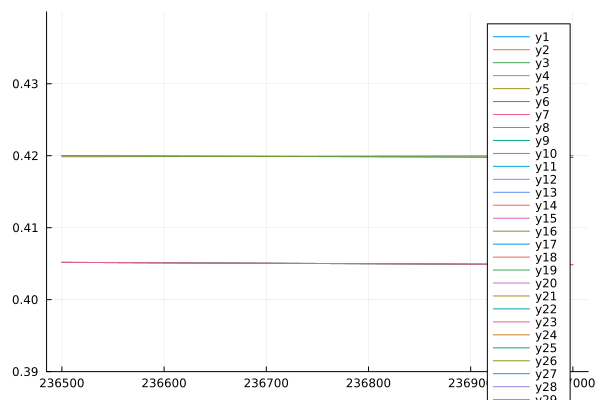

In [112]:
energy = energies(sols_E)

plot(Escan, energy[:, :]', ylims = (0.39,0.44))


1

In [267]:
using PlotlyJS
using Colors
import CairoMakie


function set_figure_style!(p; title = "", ylabel = "", xlabel ="")
    relayout!(p,
        title=title, 
        xaxis=attr(
            title=xlabel, 
            showline=true,
            linecolor="black",
            mirror=true,
            ticks="outside",
            gridcolor="lightgrey"
        ),
        yaxis=attr(
            title=ylabel, 
            showline=true,
            linecolor="black",
            mirror=true,
            ticks="outside",
            gridcolor="lightgrey"
        ),
        plot_bgcolor="white",
        width=1000,
        height=400
    )
end
plotScan(mol::moleculeInteraction, sol_vec; stateOI = [nothing, nothing, nothing], units = "K", maxDisplay = 300) = plotScan(PlotlyJS.plot(), mol::moleculeInteraction, sol_vec; stateOI = stateOI, units = units, maxDisplay = maxDisplay)
function plotScan(p::PlotlyJS.SyncPlot, mol::moleculeInteraction, sol_vec; stateOI = [nothing, nothing, nothing], units = "K", maxDisplay = 300)
    yConv = Dict("K"=> 1/1e6, "uK" => 1)

    xlabel = ["E-Field (V/cm)","R (a0)"]
    conv = [1e5,BohrRadius.val]
    
    x_var = hcat([[sol_i.Ef, sol_i.R] for sol_i in sol_vec]...)
    x_varOI = argmax([maximum(abs.(diff(x_var[i, :])[1])) for i in 1:size(x_var, 1)])
    
    AMNodes = endNode(H.M.basisTree)
    basisUC_Full = getBasisUC(mol.M.basisTree)
    basisUC = [getBasis(node.spin) for node in AMNodes]
    kronStateOI = [zeros(Int64, length(basis)) for basis in basisUC]
    for (ind, basisNode) in enumerate(basisUC)
        if stateOI[ind] == nothing
    
            kronStateOI[ind] .= 1
        else 
            subIndOI = findfirst(isequal(stateOI[ind]), basisNode)
            kronStateOI[ind][subIndOI] = 1
        end
    end
    
    stateOIind = findall(kron(kronStateOI...) .== 1)
    function findStateVec(sol_end::sol, stateOIs::Vector{Int64})
        outputVec = zeros(Int64, length(stateOIs))
    
        vec_end = sol_end.vec
        arrayOI = zeros(Float64, size(vec_end, 1), length(stateOIs))
        for col in 1:size(arrayOI, 2)
            arrayOI[stateOIs[col], col] = 1
        end
    
        B = zeros(ComplexF64, size(vec_end))
        for j in 1:size(vec_end, 2)
            max_index = argmax(abs.(vec_end[:, j]))
            B[max_index, j] = vec_end[max_index, j]
        end
        maxOverlapMat = B'*arrayOI
        for col in 1:size(maxOverlapMat, 2)
            outputVec[col] = argmax(abs.(maxOverlapMat[:, col]))
        end
        unique(outputVec)
    end
    
    adiabaticInd = argmax([sol_i.R for sol_i in sol_vec])
    filteredStateOI = findStateVec(sol_vec[adiabaticInd], stateOIind)
    filteredStateOI = length(filteredStateOI) > maxDisplay ? filteredStateOI[1:maxDisplay] : filteredStateOI
    
    #p = PlotlyJS.plot()
    for state in filteredStateOI
        PlotlyJS.addtraces!(p, PlotlyJS.scatter(x = x_var[x_varOI, :]/conv[x_varOI], y = [sol_i.val[state] for sol_i in sol_vec]*yConv[units], text=[KetName(sol_i.vec[:, state], basisUC_Full, QMorder = [6, 5, 4, 3, 2, 1]) for sol_i in sol_vec], name = "State $state"))
    end
    set_figure_style!(p, title = "Energy Spectrum", xlabel = xlabel[x_varOI], ylabel = "Energy ($(units))")
    p
end


plotScan (generic function with 2 methods)

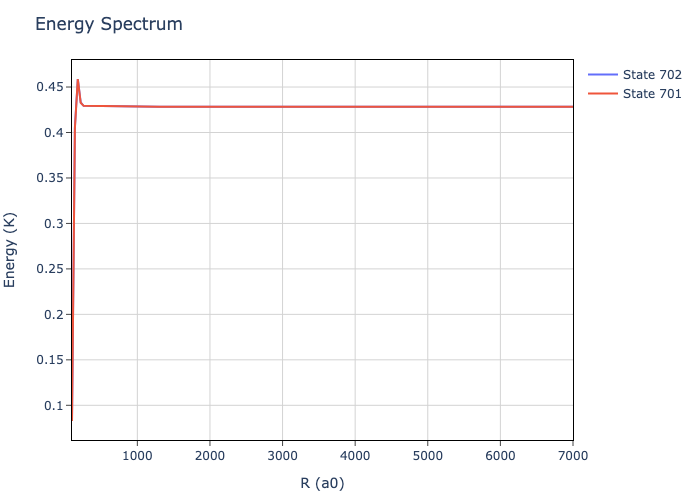

In [268]:
p = plotScan(H, sols_R, stateOI = [[0.0, 2.0], [0.0, 1.0], [0.0, 1.0]], units = "K")
plotScan(p, H, sols_R, stateOI = [[0.0, 0.0], [0.0, 1.0], [0.0, 1.0]], units = "K")

In [206]:
stateOI = [nothing, [-1, 1], nothing]

sol_vec = sols_R
x_var = hcat([[sol_i.Ef, sol_i.R] for sol_i in sol_vec]...)
x_varOI = argmax([maximum(abs.(diff(x_var[i, :])[1])) for i in 1:size(x_var, 1)])

AMNodes = endNode(H.M.basisTree)
basisUC = [getBasis(node.spin) for node in AMNodes]
kronStateOI = [zeros(Int64, length(basis)) for basis in basisUC]
for (ind, basisNode) in enumerate(basisUC)
    if stateOI[ind] == nothing

        kronStateOI[ind] .= 1
    else 
        subIndOI = findfirst(isequal(stateOI[ind]), basisNode)
        kronStateOI[ind][subIndOI] = 1
    end
end

stateOIind = findall(kron(kronStateOI...) .== 1)
function findStateVec(sol_end::sol, stateOIs::Vector{Int64})
    outputVec = zeros(Int64, length(stateOIs))

    vec_end = sol_end.vec
    arrayOI = zeros(Float64, size(vec_end, 1), length(stateOIs))
    for col in 1:size(arrayOI, 2)
        arrayOI[stateOIs[col], col] = 1
    end

    B = zeros(ComplexF64, size(vec_end))
    for j in 1:size(vec_end, 2)
        max_index = argmax(abs.(vec_end[:, j]))
        B[max_index, j] = vec_end[max_index, j]
    end
    maxOverlapMat = B'*arrayOI
    for col in 1:size(maxOverlapMat, 2)
        outputVec[col] = argmax(abs.(maxOverlapMat[:, col]))
    end
    unique(outputVec)
end




findStateVec (generic function with 1 method)

In [123]:
Escan = 2.65*1e5
#stateOI = State( [0.0, 0.0, 1.0, 1.0.0, 1.0, 1], H);
r_scan = [collect(100:40:500);collect(500:400:3000);collect(3000:1000:7000)].*a0

sols_R = scan(H, r_scan, Escan);

In [127]:
using JLD2
save_object("mytuple.jld2", (r_scan, sols_R))

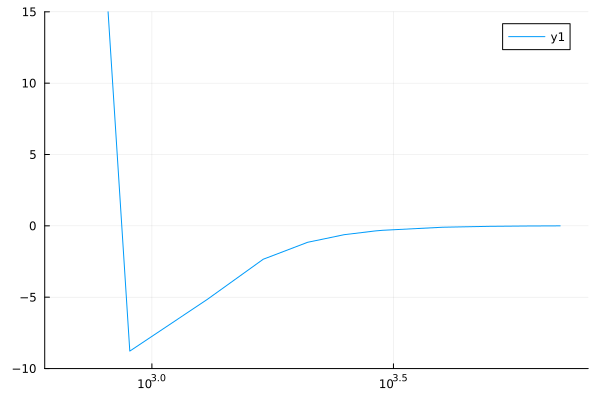

In [232]:
energy = energies(sols_R)
var =701
plot(r_scan/a0, energy[var, :]*1e6.-energy[var, end]*1e6,ylims = (-10,15), xlims=(600,8000), xaxis=:log)


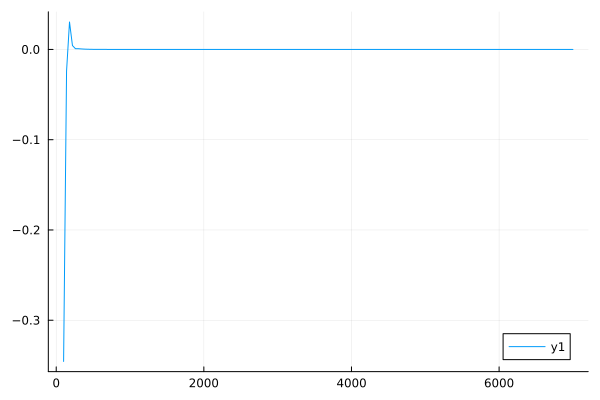

In [231]:
plot(r_scan/a0, energy[var, :].-energy[var, end])

In [83]:
using Plots

In [98]:
Escan_2 = 2.30*1e5

r_scan = [collect(100:40:500);].*a0

sols_R_2 = scan(H, r_scan, Escan_2);

In [115]:
energy = energies(sols_R_2)
var =701
plot(r_scan/a0, energy[var, :]*1e6.-energy[var, end]*1e6,ylims = (-100,100), xlims=(600,8000), xaxis=:log)


UndefVarError: UndefVarError: sols_R_2 not defined

In [95]:
KetName(sols_R_2[end].vec[:, 701], H)

"0.234 | 1, 0, 1, 0, 0, 0 > + 0.132 | 0, 0, 1, 0, 0, 0 > + 0.132 | 1, 0, 0, 0, 0, 0 >"

In [87]:
using Plots

In [34]:
using Plots

In [38]:
energy[:, 1]

7168-element Vector{Float64}:
 -1.774739609607837e7
 -1.7747264566704202e7
 -1.7747264566704195e7
 -1.7746869899690114e7
 -1.7746869899690107e7
 -1.774621185816465e7
 -1.7746211858164642e7
 -1.7745290046685e7
 -1.7745290046684995e7
 -1.7744103910246033e7
  ⋮
  2.2740413276153035e7
  2.2740949692967877e7
  2.274094969296789e7
  2.274252597914199e7
  2.2742525979142003e7
  2.2912107447548967e7
  2.2914102607137084e7
  2.2914102607137155e7
  2.295703203971659e7

In [204]:
sols_E[end].vec*sols_E[end].vec[3,:]

4096-element Vector{ComplexF64}:
 -4.1463776512884305e-15 + 0.0im
   4.062448838978322e-17 + 0.0im
      1.0000000000000095 + 0.0im
  -5.786976314931358e-17 + 0.0im
 -4.3661347452784046e-18 + 0.0im
  1.5996819292158028e-17 + 0.0im
  -2.064197955612676e-14 + 0.0im
   8.573037820215992e-17 + 0.0im
 -4.0815291470763896e-18 + 0.0im
  1.3165272822755875e-18 + 0.0im
                         ⋮
  2.7495068617729045e-33 + 0.0im
  -5.185830301878648e-39 + 0.0im
   6.668340914025732e-23 + 0.0im
   6.504851876243985e-23 + 0.0im
  1.3290032161516924e-25 + 0.0im
  1.0842906267036447e-24 + 0.0im
  -7.460694399718168e-33 + 0.0im
   7.189577353326683e-42 + 0.0im
                     0.0 + 0.0im

In [155]:
stateOI = State( [0.0, 0.0, 0.0, 1.0, 0.0, 1], H);


6-element Vector{Int64}:
 0
 0
 0
 1
 0
 1

In [117]:
stateOI = State( [0.0, 0.0, 0.0, 1.0, 0.0, 1], H);
state, energy_1010 = adiabats(Ket(stateOI), sols_R)
#stateOI = State( [1.0, 1.0, 0, 2.0, 0, 0.0], H);
#state, energy_0020 = adiabats(Ket(stateOI), sols_R);

state: 141


(ComplexF64[1.0114759230082857e-15 + 0.0im, 1.5504641557583856e-16 + 0.0im, -6.129130339267196e-17 + 0.0im, -3.2468970426734055e-17 + 0.0im, 9.025935263212708e-18 + 0.0im, -1.039430949651333e-17 + 0.0im, -1.0852649326019378e-18 + 0.0im, -3.217025388637314e-18 + 0.0im, -2.386536560445358e-18 + 0.0im, -1.939609240311123e-20 + 0.0im  …  -7.781389708941104e-19 + 0.0im, 3.7037436067971634e-21 + 0.0im, -3.3429858252035107e-22 + 0.0im, -7.3630269850535e-24 + 0.0im, -8.942176696745859e-23 + 0.0im, -1.4896832717278754e-22 + 0.0im, -9.100688021128025e-24 + 0.0im, -6.642256639262588e-22 + 0.0im, -1.9504909179209642e-23 + 0.0im, 7.710163405126146e-23 + 0.0im], [-1.1539732731327515e7, -3.1533295993078244e6, -718532.6800610013, -91694.5569499988, -63185.982418582906, -30605.984895958107, -15350.757810423893, -8192.494308924186, -4607.771267097662, -2710.3131757834344  …  -4.110693269787589, -0.7460767908050912, -0.20248851120413747, -0.07003899736446328, -0.02847926960384939, -0.02318770829879213, -

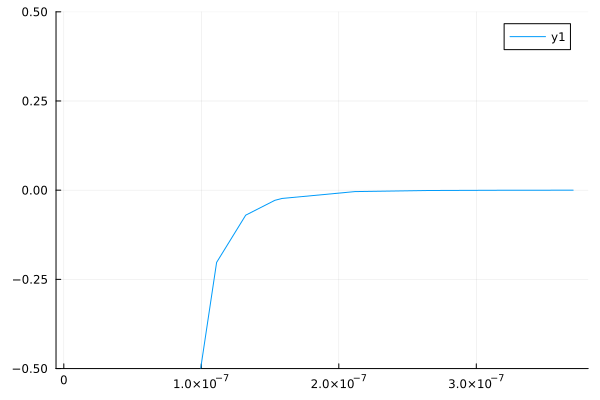

In [121]:
plot(r_scan, energy_1010, ylim = (-0.5, 0.5), xlim=:log)

In [170]:
es = energies(sols_E)

4096×21 Matrix{Float64}:
 -1.07872e5  -109453.0        …  -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0           -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0           -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0           -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0           -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0        …  -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0           -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0           -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0           -1.37151e5  -1.38824e5  -1.40502e5
 -1.07872e5  -109453.0           -1.37151e5  -1.38824e5  -1.40502e5
  ⋮                           ⋱                           ⋮
  1.32023e6        1.32088e6      1.33282e6   1.33357e6   1.33433e6
  1.32023e6        1.32088e6      1.33282e6   1.33357e6   1.33433e6
  1.32023e6        1.32088e6      1.33282e6   1.33357e6   1.33433e6
  1.32023e6        1.32088e6  …

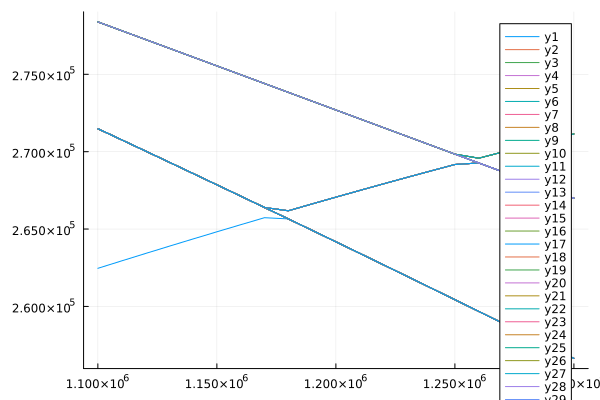

In [230]:
plot(Escan, hcat([es[i, :] for i in [320:410... 386]]...))

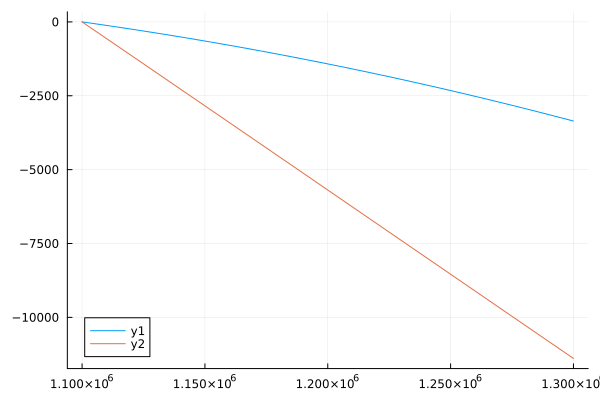

In [165]:
plot(Escan, energy_1010)
plot!(Escan, energy_0020)

In [133]:
Rscan = [70:50:500...]*a0
sols = scan(H, Rscan, 11.5e5);

In [133]:
KetName(sols_R[end].vec[:, 701], H)

"0.235 | 1, 0, 1, 0, 0, 0 > + 0.158 | 0, 0, 1, 0, 0, 0 > + 0.158 | 1, 0, 0, 0, 0, 0 >"

In [125]:
basisUC = getBasisUC(H.M.basisTree)
basisUC[701]

6-element Vector{Int64}:
 -1
  2
 -1
  3
  0
  3

state: 177


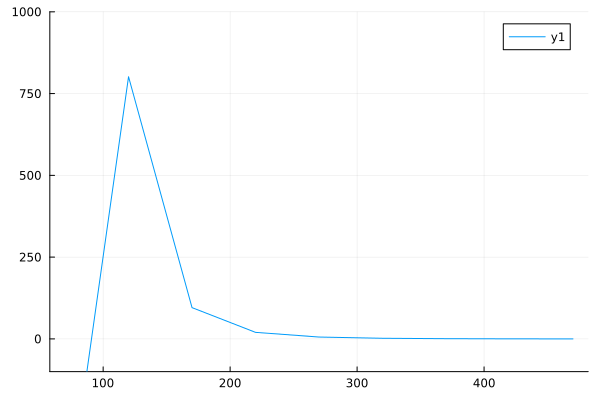

In [134]:
stateOI = State( [1.0, 1.0, 0, 1.0, 0, 1], H);
state, energy = adiabats(Ket(stateOI), sols)

plot(Rscan/a0, energy)
ylims!((-100, 1000))

In [302]:
using PhysicalConstants.CODATA2018
a0 = BohrRadius.val
Rscan = [70:50:1000...]*a0
Energies = hcat([Upot(H, r_i, 12.670e5) for r_i in Rscan]...)

729×19 Matrix{Float64}:
      -1.38125e5       -1.3473e5   …     -1.34603e5     -1.34603e5
 -136313.0             -1.34668e5        -1.34603e5     -1.34603e5
 -136313.0             -1.34668e5        -1.34603e5     -1.34603e5
      -1.36017e5  -134657.0              -1.34603e5     -1.34603e5
      -1.36017e5  -134657.0              -1.34603e5     -1.34603e5
      -1.35388e5       -1.34631e5  …     -1.34603e5     -1.34603e5
      -1.35388e5       -1.34631e5        -1.34603e5     -1.34603e5
      -1.35198e5       -1.34629e5        -1.34603e5     -1.34603e5
      -1.34868e5       -1.34614e5        -1.34603e5     -1.34603e5
  -25887.1           8270.22          13879.1        13880.8
       ⋮                           ⋱                 
       9.7248e5         7.42803e5  …      7.1599e5       7.1599e5
       9.76172e5        7.44516e5         7.1599e5       7.1599e5
       9.76172e5        7.44585e5         7.1599e5       7.1599e5
       9.76796e5        7.44585e5         7.1599e5       7.1

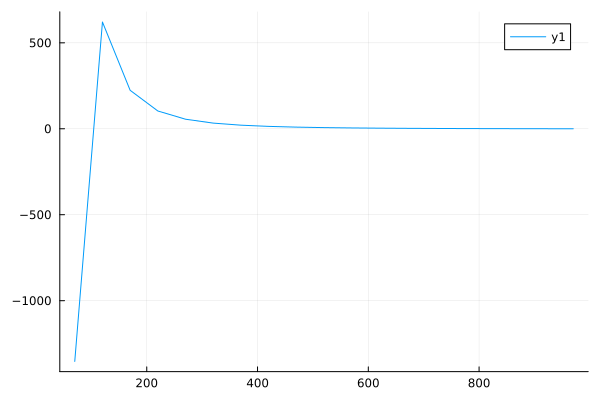

In [303]:
indOI = 30
plot(Rscan/a0, Energies[indOI, :] .-  Energies[indOI, end])


In [245]:
Escan = [0:1:25...]*1e5
Energies = hcat([Upot(H, 1e6, E_dc) for E_dc in Escan]...)

729×26 Matrix{Float64}:
 -2.22681e-5  -2.48833e7   -9.83534e7   …  -7.09264e9   -7.4954e9
 -1.08696e-5  -2.48833e7   -9.83534e7      -7.09264e9   -7.4954e9
 -3.2922e-6   -2.48833e7   -9.83534e7      -7.09264e9   -7.4954e9
  0.0         -2.48833e7   -9.83534e7      -7.09264e9   -7.4954e9
  1.00465e-5  -2.48833e7   -9.83534e7      -7.09264e9   -7.4954e9
  1.05126e-5  -2.48833e7   -9.83534e7   …  -7.09264e9   -7.4954e9
  1.22731e-5  -2.48833e7   -9.83534e7      -7.09264e9   -7.4954e9
  1.85092e-5  -2.48833e7   -9.83534e7      -7.09264e9   -7.4954e9
  2.03016e-5  -2.48833e7   -9.83534e7      -7.09264e9   -7.4954e9
  2.2279e9     2.21172e9    2.16379e9      -2.9092e9    -3.21626e9
  ⋮                                     ⋱                ⋮
  1.33674e10   1.33774e10   1.34074e10  …   1.83183e10   1.86732e10
  1.33674e10   1.33774e10   1.34074e10      1.83183e10   1.86732e10
  1.33674e10   1.33774e10   1.34074e10      1.83183e10   1.86732e10
  1.33674e10   1.33774e10   1.34074e10      1.83183e

In [98]:
using Plots

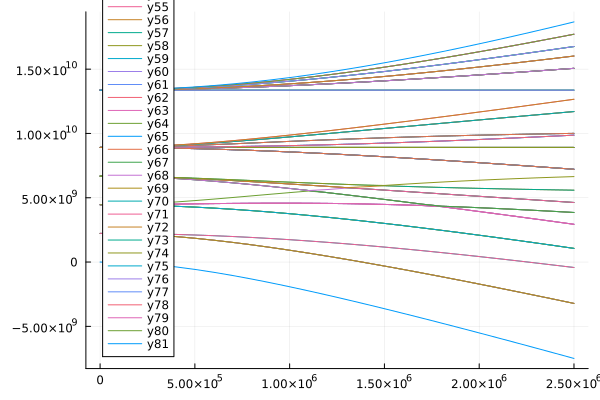

In [159]:
plot(Escan, Energies')

In [161]:
function generatePermutationMatrix(d::Int)
    # Initialize a zero matrix of size d^2 x d^2
    P = zeros(Int, d^2, d^2)

    # Fill in the permutation matrix
    for i in 1:d
        for j in 1:d
            # Initial basis index (e_i ⊗ f_j)
            initialIndex = (i - 1) * d + j

            # Target basis index (f_j ⊗ e_i)
            targetIndex = (j - 1) * d + i

            # Set the corresponding entry in the permutation matrix to 1
            P[targetIndex, initialIndex] = 1
        end
    end

    return P
end

# Example usage for a 2-dimensional space (d=2)
P = generatePermutationMatrix(3)


9×9 Matrix{Int64}:
 1  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  1  0  0
 0  1  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  1  0
 0  0  1  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  1